# Chap02 - 시작하기 전에: 신경망의 수학적 구성요소

## 2.1 신경망과의 첫 만남

In [1]:
import tensorflow as tf

tf.keras.__version__

'2.1.6-tf'

### 2.1.1 MNIST 분류기 구현

#### 1) Data Load

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images.shape :', train_images.shape)
print('train_labels.shape :', train_labels.shape)
print('test_images.shape :', test_images.shape)
print('test_labels.shape :', test_labels.shape)

train_images.shape : (60000, 28, 28)
train_labels.shape : (60000,)
test_images.shape : (10000, 28, 28)
test_labels.shape : (10000,)


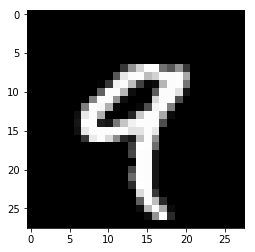

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

digit = train_images[4]
plt.imshow(digit, cmap='gray');

In [4]:
# pre-processing
train_images = train_images.reshape([-1, 28*28])
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape([-1, 28*28])
test_images = test_images.astype('float32') / 255

print('train_images.shape :', train_images.shape)
print('train_labels.shape :', train_labels.shape)
print('test_images.shape :', test_images.shape)
print('test_labels.shape :', test_labels.shape)

train_images.shape : (60000, 784)
train_labels.shape : (60000,)
test_images.shape : (10000, 784)
test_labels.shape : (10000,)


#### 2) Classifier

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

# model
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28*28,)))
network.add(layers.Dense(10, activation='softmax'))

# compile
network.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# summary
# network.get_input_shape_at(0)
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


#### 3) Training

In [6]:
# Train
network.fit(x=train_images, y=train_labels, epochs=5, batch_size=128)  # batch_size : default=32

Epoch 1/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.2533 - acc: 0.9277
Epoch 2/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.1029 - acc: 0.9695
Epoch 3/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.0680 - acc: 0.9792
Epoch 4/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.0492 - acc: 0.9852
Epoch 5/5
60000/60000 [==============================] - 5s 84us/step - loss: 0.0367 - acc: 0.9889


#### 4) Evaluating

In [7]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_loss : {:.5f}, test_acc : {}'.format(test_loss, test_acc))

10000/10000 [==============================] - 1s 69us/step
test_loss : 0.06694, test_acc : 0.9793


In [8]:
from show_graph import show_graph

show_graph(tf.get_default_graph())

#### 5) Keras vs TensorFlow 

In [9]:
import sys
import numpy as np

def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_images, batch_labels = features[batch_idx], labels[batch_idx]
        yield batch_images, batch_labels

In [6]:
# reset graph
tf.reset_default_graph()

# placeholder
inputs = tf.placeholder(tf.float32, shape=[None, 28*28])
labels = tf.placeholder(tf.int32, shape=[None])

# model
network = tf.layers.dense(inputs=inputs, units=512, activation=tf.nn.relu)
logits = tf.layers.dense(network, 10, activation=None)

# loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
# optimizer
train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss)

# metrics
correct = tf.nn.in_top_k(predictions=logits, targets=labels, k=1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [11]:
# Train
n_epochs = 5
batch_size = 128

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    n_batches = len(train_images) // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            batch_images, batch_labels = next(shuffle_batch(train_images, train_labels, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_images,
                                          labels: batch_labels})
        train_loss, train_acc = sess.run([loss, accuracy],
                                         feed_dict={inputs: batch_images, labels: batch_labels})
        print('\repoch: {} - train_loss: {:.4f} - train_acc: {:.4f}'.format(epoch+1,
                                                                          train_loss,
                                                                          train_acc))
    # eval
    test_loss, test_acc = sess.run([loss, accuracy],
                                   feed_dict={inputs: test_images, labels: test_labels})
    print('test_loss: {:.4f} - test_acc: {:.4f}'.format(test_loss, test_acc))

epoch: 1 - train_loss: 0.0942 - train_acc: 0.9767
epoch: 2 - train_loss: 0.0426 - train_acc: 0.9922
epoch: 3 - train_loss: 0.0058 - train_acc: 1.0000
epoch: 4 - train_loss: 0.0056 - train_acc: 1.0000
epoch: 5 - train_loss: 0.0028 - train_acc: 1.0000
test_loss: 0.0729 - test_acc: 0.9784


![](./images/keras.PNG)

## 2.2 신경망을 위한 데이터 표현

- 거의 모든 딥러닝 프레임워크는 일반적으로 **텐서(Tensor)**를 기본 데이터 구조로 사용한다.
- 텐서는 데이터를 위한 **컨테이너**(container)이다.
- 텐서는 임의의 차원(또는 축) 개수를 가지는 행렬의 일반화된 모습이다.

### 2.2.1 스칼라(Scalar, 0D tensor)

- 하나의 숫자만 담고 있는 텐서를 **스칼라**(scalar, 또는 스칼라 텐서, 0차원 텐서, 0D 텐서)라고 부른다.
- 스칼라 텐서의 차원(축 개수)은 0이다.
- NumPy의 `.ndim` 속성을 이용해 차원(축)을 확인할 수 있다. 
- 텐서의 축 개수를 **랭크(rank)**라고도 부른다.
  - 여기서 랭크는 선형대수에서 선형 독립의 개수를 의미하는 계수(rank)와는 다르다.

In [42]:
import numpy as np

# 0D Tensor
x = np.array(12)
print('x : {}\nx.ndim : {}'.format(x, x.ndim))
print('x.shape :', x.shape)

x : 12
x.ndim : 0
x.shape : ()


In [27]:
x

array(12)

### 2.2.2 벡터 (1D tensor)

- 숫자의 배열을 **벡터(vector)** 또는 1D 텐서라고 부른다. 
- 1D 텐서는 딱 하나의 축(axis)을 가진다.

In [41]:
x = np.array([12, 3, 6, 14, 7])
print('x : {}\nx.ndim : {}'.format(x, x.ndim))
print('x.shape :', x.shape)

x : [12  3  6 14  7]
x.ndim : 1
x.shape : (5,)


In [30]:
x

array([12,  3,  6, 14,  7])

- 위의 벡터는 5개의 원소를 가지고 있으므로 5차원 벡터라고 부른다.

#### Vector vs. Tensor

- Vector ⊂ Matrix ⊂ Tensor
- 벡터는 하나의 축을 따라 $N$-개의 차원을 가진 것이고, [텐서](http://sdolnote.tistory.com/entry/WhatisTensor)는 $N$-개의 축을 가진것이다. 텐서의 각 축을 따라 여러 개의 차원을 가진 벡터가 놓일 수 있다.
  - 예를들어, RGB 이미지는 3D 텐서이며, 각 축(R, G, B)을 따라 2D 텐서 즉, Matrix를 가진다.
- **차원수(dimensionality)**는 벡터 개념에서의 차원처럼 각 축을 따라 놓인 원소의 개수를 의미하기 때문에, 텐서에서는 랭크를 사용하는 것이 기술적으로 좀더 정확하다.
  - 예를들어, 5D 텐서의 경우 5차원 텐서 보다는 랭크 5인 텐서라고 말하는 것이 좋다.

### 2.2.3 행렬 (2D tensor)

- 벡터의 배열을 **행렬**(matrix) 또는 2D 텐서라고 한다. 
- 아래의 행렬을 NumPy로 나타내면 다음과 같다.

$$
\begin{bmatrix} 5 & 78 & 2 & 34 & 0 \\ 6 & 79 & 3 & 35 & 1 \\ 7 & 80 & 4 & 36 & 2 \end{bmatrix}
$$

In [40]:
x = np.array([[5, 78, 2, 34, 0], 
              [6, 79, 3, 35, 1], 
              [7, 80, 4, 36, 2]])
print('x :\n{}\nx.ndim : {}'.format(x, x.ndim))
print('x.shape :', x.shape)

x :
[[ 5 78  2 34  0]
 [ 6 79  3 35  1]
 [ 7 80  4 36  2]]
x.ndim : 2
x.shape : (3, 5)


In [33]:
x

array([[ 5, 78,  2, 34,  0],
       [ 6, 79,  3, 35,  1],
       [ 7, 80,  4, 36,  2]])

### 2.2.4 3D 텐서와 고차원 텐서

- 행렬들을 하나의 새로운 배열로 합치면 직육면체의 형태로 해석할 수 있는 3D 텐서가 만들어진다. 
- 3D 텐서들을 하나의 배열로 합치면 4D 텐서가 되며, 이런식으로 고차원 텐서를 만든다.
- 딥러닝에서는 보통 0D ~ 4D 까지의 텐서를 다룬다.

![](./images/3d-tensor.PNG)


In [43]:
x = np.array([[[5, 78, 2, 34, 0], 
               [6, 79, 3, 35, 1], 
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0], 
               [6, 79, 3, 35, 1], 
               [7, 80, 4, 36, 2]], 
              [[5, 78, 2, 34, 0], 
               [6, 79, 3, 35, 1], 
               [7, 80, 4, 36, 2]]])
print('x :\n{}\nx.ndim : {}'.format(x, x.ndim))
print('x.shape :', x.shape)
print('x.dtype :', x.dtype)

x :
[[[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]

 [[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]

 [[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]]
x.ndim : 3
x.shape : (3, 3, 5)
x.dtype : int32


In [37]:
x.ndim

3

### 2.2.5 핵심 속성

- 텐서는 3개의 핵심 속성으로 정의된다.
  - **Rank(축의 개수)** : 예를 들어 3D 텐서에는 3개의 축이 있고, 행렬에는 2개의 축이 있다. NumPy의 `.ndim` 을 통해 확인할 수 있다.
  - **Shape(형태)** : 텐서의 각 축을  따라 얼마나 많은 차원이 있는지를 나타내는 Python의 tuple이다. NumPy의 `.shape`을 통해 확인할 수 있다.
  - **Data type** : 텐서에 포함된 데이터의 타입이다.
    - `.dtype`을 통해 확인 가능하다.
    - `float32, float64, uint8, int32`등
    - 텐서는 사전에 할당되어 메모리에 저장되어야 하기 때문에 가변 길이의 문자열을 지원하지 않는다.

### 2.2.6 NumPy로 텐서 조작하기

- 배열에 있는 특정 원소들을 선택해는 것을 **슬라이싱(slicing)** 이라고 한다.

In [45]:
x = np.array([[[5, 78, 2, 34, 0], 
               [6, 79, 3, 35, 1], 
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0], 
               [6, 79, 3, 35, 1], 
               [7, 80, 4, 36, 2]], 
              [[5, 78, 2, 34, 0], 
               [6, 79, 3, 35, 1], 
               [7, 80, 4, 36, 2]]])

print('x :\n{}\nx.ndim : {}'.format(x, x.ndim))
print('x.shape :', x.shape)

x :
[[[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]

 [[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]

 [[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]]
x.ndim : 3
x.shape : (3, 3, 5)


#### Slicing

In [47]:
x_slice = x[:2]
print('x_slice.shape :', x_slice.shape)

x_slice.shape : (2, 3, 5)


In [48]:
x_slice = x[:2, :, :]
print('x_slice.shape :', x_slice.shape)

x_slice.shape : (2, 3, 5)


In [49]:
x_slice = x[:2, :2, :2]
print('x_slice.shape :', x_slice.shape)
print('x_slice :\n{}\nx_slice.ndim : {}'.format(x_slice, x_slice.ndim))

x_slice.shape : (2, 2, 2)
x_slice :
[[[ 5 78]
  [ 6 79]]

 [[ 5 78]
  [ 6 79]]]
x_slice.ndim : 3


### 2.2.7 배치 데이터

- 일반적으로 딥러닝에서 사용하는 모든 데이터 텐서의 첫 번째 축은 **샘플 축(sample axis)** 이라고 한다.
- 딥러닝 모델은 한 번에 전체 데이터셋을 가지고 학습하지 않고, 전체 데이터셋에서 일부 데이터를 샘플링해 학습하는데, 이를 **배치(batch)** 라고 한다.
- 배치 데이터에서 첫 번째 축을 **배치 축(batch axis)** 또는 **배치 차원(batch dimension)**이라고 한다.

### 2.2.8 텐서의 실제 사례

딥러닝에서 자주 사용하게될 텐서는 다음과 같은 것들이 있다.

- **벡터 데이터** : `(samples, features)` 형태의 2D 텐서
    - (나이, 우편번호, 소득)으로 구성된 통계 데이터, `(N, 3)`
- **시계열 데이터** 또는 **시퀀스 데이터** : `(samples, timesteps, features)` 형태의 3D 텐서
    - 주식 가격 데이터셋은 (250일치, 하루거래시간(분), (현재, 최소, 최고)) → `(250, 390, 3)` 
- **이미지** : `(samples, height, width, channels)` 또는 `(samples, channels, height, width)` 형태의 4D 텐서
    - MNIST 데이터 셋 (배치, 높이, 너비, 채널) → `(N, 28, 28, 1)` 
- **동영상** : `(samples, frames, height, width, channels)` 또는 `(samples, frames, channels, height, width)` 형태의 5D 텐서
    - 60초 짜리 144$\times$256 유튜브 비디오 클립을 초당 4프레임으로 샘플링하면 240 프레임이며, 이런 비디오 클립을 4개 가진 배치는 `(4, 240, 144, 256, 3)` 텐서에 저장된다.

## 2.3 텐서 연산

### 2.3.1 원소별(element-wise) 연산

- 원소별 연산(element-wise operation)은 텐서에 있는 각 원소에 독립적으로 적용되는 연산을 말한다. 
- NumPy는 텐서의 원소별 연산을 제공하여 빠르게 처리할 수 있다.

In [55]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

x = np.array([[-1, 1], 
              [-2, 3]])

print('relu(x) :\n{}'.format(relu(x)))

relu(x) :
[[0 1]
 [0 3]]


### 2.3.2 브로드캐스팅 (Broadcasting)

- Broadcast의 사전적인 의미는 '퍼뜨리다'라는 뜻이 있는데, 이와 마찬가지로 두 텐서 A, B 중 크기가 작은 텐서를 크기가 큰 텐서와 형태(shape)가 맞게끔 늘려주는 것을 의미한다.

- 브로드캐스팅은 두 단계로 이루어진다.

  - ① 큰 텐서의 랭크(차원)에 맞도록 작은 텐서에 축(axis)이 추가된다.
  - ② 작은 텐서가 새 축을 따라서 큰 텐서의 형태에 맞도록 반복된다.


![broadcasting](./images/broadcasting.png)

In [65]:
import numpy as np

w = np.array([[1, 2, 3], 
              [4, 5, 6], 
              [7, 8, 9]])
b = np.array([1])

h = w - b

print('w.shape : {}, b.shape : {}'.format(w.shape, b.shape))
print('w.ndim : {}, b.ndim : {}'.format(w.ndim, b.ndim))
print('h.ndim : {}\n{}'.format(h.ndim, h))

w.shape : (3, 3), b.shape : (1,)
w.ndim : 2, b.ndim : 1
h.ndim : 2
[[0 1 2]
 [3 4 5]
 [6 7 8]]


### 2.3.3. 텐서 점곱 (tensor dot)

- **텐서 곱셈**(tensor product)라고도 한다.

- NumPy, Keras에서는 `.dot`을 이용해 텐서 곱셈을 수행한다.
- 고차원 텐서 간의 곱셈은 다음과 같이 할 수 있다.
  - `(a, b, c, d) ∙ (d,) → (a, b, c)`
  - `(a, b, c, d) ∙ (d, e) → (a, b, c, e) `  

![](./images/dot.PNG)


$$
\begin{bmatrix} 1 & 4 \\ 2 & 5 \\ 3 & 6 \end{bmatrix}\cdot \begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \end{bmatrix}=\begin{bmatrix} 17 & 22 & 27 \\ 22 & 29 & 36 \\ 27 & 36 & 45 \end{bmatrix}
$$

In [82]:
import numpy as np

x = np.array([[1, 4], 
              [2, 5], 
              [3, 6]])
y = np.array([[1, 2, 3], 
              [4, 5, 6]])

z = np.dot(x, y)

print('x.shape : {}, y.shape : {}'.format(x.shape, y.shape))
print('z.shape : {}\n{}'.format(z.shape, z))

x.shape : (3, 2), y.shape : (2, 3)
z.shape : (3, 3)
[[17 22 27]
 [22 29 36]
 [27 36 45]]


In [83]:
# in keras
from tensorflow.keras import backend as K

x = K.constant(x)
y = K.constant(y)
z = K.dot(x, y)

with tf.Session() as sess:
    z = z.eval()
    
print(z)

[[17. 22. 27.]
 [22. 29. 36.]
 [27. 36. 45.]]


### 2.3.4 텐서 형태 변환

- 텐서 형태 변환(tensor reshaping)은 특정 형태에 맞게 행과 열을 재배열 한다는 뜻이다.
- NumPy의 `.reshape()`을 이용해 형태를 변환할 수 있다.

In [105]:
import numpy as np

x = np.array([[0, 1], 
              [2, 3], 
              [4, 5]])

print('x.shape :', x.shape)

x = x.reshape([6, -1]) # == [6, 1]
print('x.shape : {}\n{}'.format(x.shape, x))

x = x.reshape([2, -1]) # == [2, 3]
print('x.shape : {}\n{}'.format(x.shape, x))

# Transpose - 1
x = np.transpose(x)  # == x.T
print('x.shape : {}\n{}'.format(x.shape, x))

# Transpose - 2
x = np.transpose(x,  (1, 0))  # == x.T
print('x.shape : {}\n{}'.format(x.shape, x))

x.shape : (3, 2)
x.shape : (6, 1)
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]
x.shape : (2, 3)
[[0 1 2]
 [3 4 5]]
x.shape : (3, 2)
[[0 3]
 [1 4]
 [2 5]]
x.shape : (2, 3)
[[0 1 2]
 [3 4 5]]


### 2.3.5 텐서 연산의 기하학적 해석

- 텐서 연산은 일반적으로 아핀변환(affine transformation) 회전, 스케일링(scaling) 등 기본적인 기하학적 연산을 표현할 수 있다.
- **Affine transformation** : [아핀 변환](https://en.wikipedia.org/wiki/Affine_transformation)은 점, 직선, 평면을 보존하는 아핀 공간으로의 변환을 의미한다. 이 변환은 거리의 비율과 직선의 평행을 유지하는 이동, 스케일링, 회전 등이 포함된다.
  - Affine Space : 아핀공간은 벡터공간을 평행이동한 것이라 할 수 있다. 


$$
\vec{y} = f(\vec{x}) = \mathbf{W}\vec{x} + \vec{b}
$$



- 따라서, Fully-Connected layer를 **Affine layer**라고도 한다.

![](./images/affine.PNG)

## 2.4 그래디언트 기반 최적화

- 딥러닝 모델의 학습 초기에는 가중치($\mathbf{W}$) 파라미터는 랜덤하게 초기화된다. → [여기](http://excelsior-cjh.tistory.com/177?category=940400) 참고
- 학습이 진행되면서 [역전파](http://excelsior-cjh.tistory.com/171?category=940400)(backpropagation)에 의해 가중치가 업데이트 된다.
- 학습 과정은 다음과 같다. → [여기](http://excelsior-cjh.tistory.com/172?category=940400) 참고

1. 먼저, 각 학습 데이터 샘플을 네트워크에 입력으로 넣어주고 출력층까지 각 층의 뉴런 마다 출력을 계산한다. 이를 **순전파**(forward propagation)이라고 한다. 

2. 그 다음 네트워크의 마지막 출력층에 대한 결과(예측값)와 실제값과의 차이, 즉 오차(error)를 계산하는데, 손실함수(loss function)를 이용하여 계산한다.

3. 그리고 이 오차를 역방향으로 흘러 보내면서, 각 출력 뉴런의 오차에 마지막 입력 뉴런이 얼마나 기여했는지 측정한다. 이말을 쉽게 설명하면, **각 뉴런의 입력값에 대한 손실함수의 편미분, 그래디언트(gradient)을 계산**하는 것을 말한다.

4. 3번과 같은 방법을 입력층에 도달할 때까지 계속 반복해서 역방향으로 흘러 보낸다.

5. 마지막으로, 계산한 그래디언트를 네트워크의 모든 가중치 매개변수에 반영해주는 **경사 하강법 단계**를 수행한다.



- **그래디언트**(gradient)는 텐서 연산의 변화율을 의미한다.

### 2.4.1 확률적 경사 하강법

- 신경망에서의 **경사 하강법**(GD, Gradient Descent)는 손실함수를 최소화하기 위해 반복해서 가중치 파라미터를 조정해 나가는 것이라고 할 수 있다.
- 신경망에서는 층이 깊어질수록 가중치 파라미터의 수가 엄청나게 많아지기 때문에 수식을 풀어서 한번에 최적의 값을 찾을 수 없다.
- 따라서, 일반적으로 **미니 배치 확률적 경사 하강법**(mini-batch stochastic gradient descent)을 사용한다. 
- 신경망처럼 고차원 공간에서는 지역 최소값(local minima)은 매우 드물게 나타나며, 대부분 안장점(saddle point)로 나타난다.
- 다양한 경사 하강법을 이용하여 손실함수를 최소화 시키는 방법을 최적화 방법(optimization)이라고 한다.
- 옵티마이저에는 SGD, Adagrad, RMSProp 등 다양한 옵티마이저가 있다.  → [여기](https://github.com/ExcelsiorCJH/DLFromScratch/blob/master/Chap06-Training_Models/[%EB%B0%91%EB%9F%AC%EB%8B%9D]_Chap06-%ED%95%99%EC%8A%B5%EA%B4%80%EB%A0%A8%EA%B8%B0%EC%88%A0%EB%93%A4.pdf) 참고



![](./images/op.gif)


## 2.5 요약

- **학습(learning)**은 학습 데이터 샘플과 그에 상응하는 타깃이 주어졌을 때 손실 함수를 최소화 하는 모델 파라미터의 조합을 찾는 것을 말한다.
- 데이터 샘플과 타깃의 배치를 랜덤하게 추출하여 이 배치에서 손실에 대한 파라미터의 그래디언트를 계산함으로써 학습이 진행된다. 가중치 파라미터는 학습률(learning rate)에 의해 그래디언트 반대 방향으로 조금씩 움직인다.
- 전체 학습 과정은 신경망이 미분 가능한 텐서 연산으로 연결되어 있기 때문에 가능하다. 
- 손실(loss)는 학습하는 동안 최소화해야 할 측정 지표이다.
- 옵티마이저(optimizer)는 손실에 대한 그래디언트가 파라미터를 업데이트하는 방식을 정의한 것이다.